In [2]:
import os, sys
sys.path.append(os.path.abspath('./src'))
import utils, json

In [3]:
# PATHS
data_path = '/scratch/juanmoo1'
EMA_dump_path = os.path.join(data_path, './jsons/EMA_dump.json')
EMA_xmls_path = os.path.join(data_path, './xmls/')
EMA_annotations_path = os.path.join(data_path, './bayer/VendorEMAforMIT/annotations.xlsx')

pickle_dumps_path = os.path.join(data_path, './pickle_dumps/')

In [4]:
# Raw Data
'''
Format:
{
    document_name <str>: {
                            element_text: <str> (raw text),
                            element_tag: <str> (TEI XML tag)
                          },
                          
    ...
}
'''
data = json.loads(open(EMA_dump_path, 'r').read())


# Labels
'''
Dict in form:
{
    file_name: {
        texts: [ <str>, ...],
        labels: [ <str>, ...]
    },
    
    ...
    
}
'''
annotations = utils.parse_spreadsheet(EMA_annotations_path)

## Matching Data to Labels

In [84]:
'''
For each document in 'data', iterate through the paragraphs and check to see if there's 
an elemenet the paragraphs of the element in 'labels' with the same name.
'''
from matplotlib.pyplot import hist, title
from fuzzywuzzy import fuzz
from time import time as time

def f1(piece, whole):
    return piece in whole

def f2(piece, whole):
    return piece.lower() in whole.lower()

def f3(piece, whole):
    threshold = 95
    return fuzz.partial_ratio(piece, whole) >= threshold

def contains_test(piece, whole):
    # test if 'piece' is a member of 'whole'
    
    test_functions = [f1, f2, f3]
    
    i = 0
    return test_functions[i](piece, whole)

In [38]:
match_frac = []
elapsed_times = []

labeled_raw_documents = {}

for parsed_doc_name in data:
    start_time = time()

    parsed_doc = data[parsed_doc_name]
    label_doc = annotations[parsed_doc_name] #label doc w/ same name
    
    matchings = [] # el: [parsed paragraph, label_paragraph_id, label]
    other = []
    
    paragraphs = []
    labels = []
    tags = []
    
    for parsed_p, tag in zip(parsed_doc['element_text'], parsed_doc['element_tag']):
        found = False
        for i, label_p in enumerate(label_doc['texts']):
            if contains_test(parsed_p, label_p): #Match
                found = True
                matchings.append([parsed_p, i, label_doc['labels'][i]])
                
                paragraphs.append(parsed_p)
                labels.append(label_doc['labels'][i])
                tags.append(tag)
                break
        if not found:
            other.append(parsed_p)
            
            paragraphs.append(parsed_p)
            labels.append('other')
            tags.append(tag)
            
    
    tot_time = time() - start_time
    elapsed_times.append(tot_time)
            
    num_texts = len(parsed_doc['element_text'])        
    match_frac.append(len(matchings)/num_texts)
    
    labeled_raw_documents[parsed_doc_name] = {
        'matches': matchings,
        'other': other,
        'paragraphs': paragraphs,
        'labels': labels,
        'tags': tags
    }        

In [39]:
import pickle

with open(os.path.join(pickle_dumps_path, 'EMA.pickle'), 'wb') as f:
    f.write(pickle.dumps(labeled_raw_documents))

In [7]:
import pickle
with open(os.path.join(pickle_dumps_path, 'EMA_fuzzy.pickle'), 'rb') as f:
    labeled_raw_documents = pickle.loads(f.read())

In [ ]:
hist(elapsed_times)
print(sum(elapsed_times))

Average Matches: 0.0507364268205674


(array([14., 17., 11.,  8.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.02475172, 0.04950344, 0.07425516, 0.09900688,
        0.12375859, 0.14851031, 0.17326203, 0.19801375, 0.22276547,
        0.24751719]),
 <a list of 10 Patch objects>)

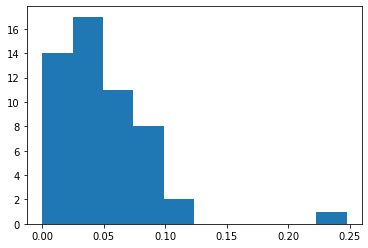

In [133]:
print("Average Matches:", sum(match_frac)/len(match_frac))
hist(match_frac)

### Conjecture:
The fraction of text in the labels is much smaller than all text. Thus, we should fail to find labels for most of extracted paragraphs

(array([11., 10.,  3.,  1.,  9.,  4.,  3.,  3.,  2.,  2.]),
 array([0.01782014, 0.03259288, 0.04736563, 0.06213837, 0.07691112,
        0.09168386, 0.10645661, 0.12122935, 0.1360021 , 0.15077484,
        0.16554759]),
 <a list of 10 Patch objects>)

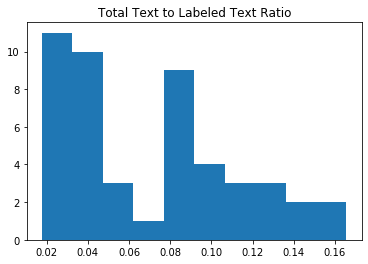

In [86]:
data_ratios = []
for parsed_doc_name in data:
    parsed_doc = data[parsed_doc_name]
    label_doc = annotations[parsed_doc_name]
    
    parsed_text = ''.join(e.strip() for e in parsed_doc['element_text'])
    label_text = ''.join(e.strip() for e in label_doc['texts'])
    
    ratio = len(label_text)/len(parsed_text)
    data_ratios.append(ratio)
data_ratios.sort()

# Cut lowest 5% and top 5%
start = int(0.05 * len(data_ratios))
end = int(0.95 * len(data_ratios))

title("Total Text to Labeled Text Ratio")
hist(data_ratios[start:end])

There seem to be missing documents:

In [87]:
anames = list(annotations.keys())
fnames = list(data.keys())

# from scipy.spatial.distance import hamming

# There's extra files referenced in the annotation spreadsheet
print('anotation names count:', len(anames))
print('document count:', len(fnames))

missing_ann = set(fnames) - set(anames)
missing_docs = set(anames) - set(fnames)

print('missing annotations count:', len(missing_ann))
print('missing doc count:', len(missing_docs))
print('missing docs:')
for doc_name in missing_docs:
    print('-', doc_name)

anotation names count: 72
document count: 53
missing annotations count: 0
missing doc count: 19
missing docs:
- blincyto-epar-product-information_en
- ameluz-epar-product-information_en
- ciambra-epar-product-information_en
- capecitabine-accord-epar-product-information_en
- caelyx-epar-product-information_en
- bemfola-epar-product-information_en
- atripla-epar-product-information_en
- afinitor-epar-product-information_en
- cholestagel-epar-product-information_en
- coaprovel-epar-product-information_en
- adempas-epar-product-information_en
- bortezomib-accord-epar-product-information_en
- arava-epar-product-information_en
- avastin-epar-product-information_en
- aldurazyme-epar-product-information_en
- aloxi-epar-scientific-discussion_en
- blitzima-epar-product-information_en
- besponsa-epar-product-information_en
- adcirca-epar-product-information_en


## Preprocessing

In [9]:
import re 
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]", "digit", string)
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [20]:
# Clean input text
processed_documents = {}

for doc_name in labeled_raw_documents:
    texts = [clean_str(raw) for raw in labeled_raw_documents[doc_name]['paragraphs']]
    labels = [l.lower() for l in labeled_raw_documents[doc_name]['labels']]
    tags = [t.lower() for t in labeled_raw_documents[doc_name]['tags']]
    
    processed_documents[doc_name] = {
        'texts': texts,
        'labels': labels,
        'tags': tags
    }

In [21]:
# Match text with the previous header
for doc_name in processed_documents:
    texts = processed_documents[doc_name]['texts']
    tags = processed_documents[doc_name]['tags']
    
    # First Header
    header_index = [-1] * len(texts)    
    last_header = 0
    
    while(last_header < len(tags) and tags[last_header] != 'head'):
        last_header += 1
        
    i = last_header + 1
    
    while i < len(tags):
        header_index[i] = last_header
        if tags[i] == 'head':
            last_header = i
        
        i += 1
    
    # Second Header
    header2 = [-1] * len(header_index)
    last_header = 0
    while(last_header < len(tags) and header_index[last_header] == -1):
        last_header += 1
    
    i = last_header + 1
    while i < len(header2):
        header2[i] = header_index[last_header]
        if header_index[i] != -1:
            last_header = i
        i += 1
        
    
    
    processed_documents[doc_name]['header_index'] = header_index
    processed_documents[doc_name]['header_index_2'] = header2


### Create testing and training sets

In [12]:
from sklearn.model_selection import ShuffleSplit
from functools import reduce
names = list(processed_documents.keys())

rs = ShuffleSplit(n_splits=1, test_size = 0.3)
split = next(rs.split(names))

train_docs = list(map(lambda i: names[i], split[0]))
test_docs = list(map(lambda i: names[i], split[1]))


X_train = reduce(lambda l, dname: l + processed_documents[dname]['texts'], [[]] + train_docs)
Y_train = reduce(lambda l, name: l + processed_documents[name]['labels'], [[]] + train_docs)


X_test = reduce(lambda l, dname: l + processed_documents[dname]['texts'], [[]] + test_docs)
Y_test = reduce(lambda l, name: l + processed_documents[name]['labels'], [[]] + test_docs)

X = X_train + X_test
Y = Y_train + Y_test

# Count Tokenization

In [13]:
# Text + Header
from sklearn.feature_extraction.text import *

# Count Tokenizer
all_texts = set()
all_headers = set()
for doc_name in processed_documents:
    texts = processed_documents[doc_name]['texts']
    labels = processed_documents[doc_name]['labels']
    header_index = processed_documents[doc_name]['header_index']
    
    all_texts = all_texts | set(texts)
    all_headers = all_headers | set([texts[i] for i in header_index if i != -1])

all_texts = sorted(list(all_texts))
all_headers = sorted(list(all_headers))

text_index = {el:i for i, el in enumerate(all_texts)}
header_index = {el:i for i, el in enumerate(all_headers)}

In [14]:
text_vectorizer = CountVectorizer(ngram_range=(1, 4))
all_texts = text_vectorizer.fit_transform(all_texts)

header_vectorizer = CountVectorizer(ngram_range=(1, 4))
all_headers = header_vectorizer.fit_transform(all_headers)

## Remove data classes with insufficient examples

In [15]:
Y_count = {el: Y.count(el) for el in set(Y)}

min_count = 10
X_train, Y_train = zip(*[(X_train[i], Y_train[i]) for i in range(len(X_train)) if Y_count[Y_train[i]] >= min_count])
X_test, Y_test = zip(*[(X_test[i], Y_test[i]) for i in range(len(X_test)) if Y_count[Y_test[i]] >= min_count])

X = X_train + X_test
Y = Y_train + Y_test

In [16]:
labels = list(set(Y))
labels.sort(key=lambda x: Y.count(x))

for l in labels:
    print('-', l[:20], '| frequency:', Y.count(l))

- significant findings | frequency: 21
- significant findings | frequency: 41
- populations - geriat | frequency: 41
- populations - paedia | frequency: 76
- populations - adult | frequency: 92
- populations - adoles | frequency: 123
- contraindication | frequency: 264
- significant findings | frequency: 338
- warning | frequency: 931
- other | frequency: 25229


# Multi-Class SVN

In [17]:
#pipeline of feature engineering and model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

model = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])

## Param Search

In [308]:
#paramater selection
from sklearn.model_selection import GridSearchCV
parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
               'tfidf__use_idf': [False, True],
               'vectorizer__min_df': [0, 0.0001, 0.00001],
               'vectorizer__stop_words':[None, 'english']
             }
gs_clf_svm = GridSearchCV(model, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X, Y)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9035944242524167
{'tfidf__use_idf': True, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 4), 'vectorizer__stop_words': None}


In [223]:
# vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=0.0001)
# X2 = vectorizer.fit_transform(X)

In [224]:
# len(vectorizer.get_feature_names())

7185

In [309]:
#Training of Final Model
model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,4), min_df = 0, stop_words=None)),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])

model.fit(X_train, Y_train)
#Test
pred = model.predict(X_test)

/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [310]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, pred)
accuracy = accuracy_score(Y_test, pred)

class_count = len(cm)

class_accuracy = [cm[i][i]/sum(cm[i]) if sum(cm[i]) > 0 else 0 for i in range(class_count)]
w_acc = [class_accuracy[i] * sum(cm[i]) for i in range(len(cm))]
acc_no_other = (sum(w_acc) - w_acc[1])/(sum(sum(cm[i]) for i in range(class_count)) - sum(cm[1]))
                                        
print(cm)
print('Class Acuracy:', class_accuracy)
print('Overall Accuracy:', accuracy)
print('Accuracy excluding other:', acc_no_other)

[[  67   15    0    0    0    0    0    3    0    1]
 [  22 7619   84   28   46   41   18   80    0  147]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    2    0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    2    1    0    0    1    0    0    0    0]
 [   0    2    0    0    0    0    0    0    0    0]
 [   0   36    0    0    0    0    0   76    0    0]
 [   0    7    0    0    0    0    0    0    0    0]
 [  18  140    0    0    1    0    2    0    0   86]]
Class Acuracy: [0.7790697674418605, 0.9423623995052567, 0, 0.0, 0, 0.25, 0.0, 0.6785714285714286, 0.0, 0.3481781376518219]
Overall Accuracy: 0.9184413760823777
Accuracy excluding other: 0.49891540130151846


In [311]:
categories = dict()
for real, prediction in zip(Y_test, pred):
    if real not in categories:
        categories[real] = [0,0] #total, correct
    categories[real][0] += 1
    categories[real][1] += (real == prediction)
    
for c in categories:
    tot = categories[c][0]
    corr = categories[c][1]
    acc = corr/tot
#     print(c + ' =>', 'total:', tot, '\t\t correct:', corr, '\t\t accuracy:', acc)
    print(c + ': acc', acc, 'total:', tot)
#     print(c + ': correct:', corr, "\t || accuracy:", acc)

other: acc 0.9423623995052567 total: 8085
populations - adult: acc 0.0 total: 3
contraindication: acc 0.7790697674418605 total: 86
significant findings - pregnancy: acc 0.6785714285714286 total: 112
significant findings - renal impairment: acc 0.0 total: 7
significant findings - hepatic impairment: acc 0.0 total: 2
populations - paediatric: acc 0.25 total: 4


### TODO's 04/01/2020
* Remove common words from text
* Remove classes with few examples
* Append Corresponding headers to examples
* Limit length of feature vector // Filter low freq words
* Stop words
* Append BOG of corresponding header
* Explore other models ?
    ** Try decision tree
    ** try small ff nn
    
* Separate train / test based on documents
* Consider paragraphs w/o labels and 'other' label.

## Using Header in the feature vector

In [18]:
sample_doc_name = list(processed_documents.keys())[0]
sample_doc = processed_documents[sample_doc_name]

sample_doc.keys()

dict_keys(['texts', 'labels', 'tags', 'header_index', 'header_index_2'])

In [159]:
import numpy as np
from scipy.sparse import hstack, vstack

# Create Feature vectors that tokenized version of last two headers
for doc_name in processed_documents:
    doc = processed_documents[doc_name]
    
    text_tokens = text_vectorizer.transform(doc['texts'])
    header_tokens = header_vectorizer.transform([doc['texts'][i] if i != -1 else "" for i in doc['header_index']])
    header2_tokens = header_vectorizer.transform([doc['texts'][i] if i != -1 else "" for i in doc['header_index_2']])
    joint_tokens = hstack([text_tokens, header_tokens, header2_tokens])
    
    doc['tokens'] = joint_tokens

In [160]:
from sklearn.model_selection import ShuffleSplit
from functools import reduce
names = list(processed_documents.keys())

rs = ShuffleSplit(n_splits=1, test_size = 0.3)
split = next(rs.split(names))

train_docs = list(map(lambda i: names[i], split[0]))
test_docs = list(map(lambda i: names[i], split[1]))

X_train = vstack([processed_documents[dname]['tokens'] for dname in train_docs])
Y_train = reduce(lambda l, name: l + processed_documents[name]['labels'], [[]] + train_docs)

X_test = vstack([processed_documents[dname]['tokens'] for dname in test_docs])
Y_test = reduce(lambda l, name: l + processed_documents[name]['labels'], [[]] + test_docs)

X = vstack([X_train , X_test])
Y = Y_train + Y_test

In [161]:
#pipeline of feature engineering and model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

model = Pipeline([('tfidf', TfidfTransformer()),
 ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])

In [162]:
#paramater selection
from sklearn.model_selection import GridSearchCV
parameters = {
               'tfidf__use_idf': [False, True],
             }

gs_clf_svm = GridSearchCV(model, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X, Y)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9366370679155664
{'tfidf__use_idf': True}


In [163]:
#Training of Final Model
model = Pipeline([
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])

model.fit(X_train, Y_train)
#Test
pred = model.predict(X_test)

/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [164]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, pred)
accuracy = accuracy_score(Y_test, pred)

class_count = len(cm)

class_accuracy = [cm[i][i]/sum(cm[i]) if sum(cm[i]) > 0 else 0 for i in range(class_count)]
w_acc = [class_accuracy[i] * sum(cm[i]) for i in range(len(cm))]
acc_no_other = (sum(w_acc) - w_acc[1])/(sum(sum(cm[i]) for i in range(class_count)) - sum(cm[1]))
                                        
print(cm)
print('Class Acuracy:', class_accuracy)
print('Overall Accuracy:', accuracy)
print('Accuracy excluding other:', acc_no_other)

[[  40   18    0    0    0    0    0    1    1    0    3]
 [  27 8292   13   20    2   37    0   12   61    0   99]
 [   0   11    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0]
 [   1   10    0    0    0    0    0    0    1    0    1]
 [   0   25    0    0    0    8    0    0    0    0    2]
 [   0    1    0    0    0    0    0    0    0    0    0]
 [   2    8    0    0    0    0    0    0    0    0    0]
 [   1   46    0    0    0    0    0    0   42    0    1]
 [   0    1    0    0    0    0    0    0    0    0    0]
 [   5  108    0    0    0    7    0    1    2    0   39]]
Class Acuracy: [0.6349206349206349, 0.9683522130094593, 0.0, 0.0, 0.0, 0.22857142857142856, 0.0, 0.0, 0.4666666666666667, 0.0, 0.24074074074074073]
Overall Accuracy: 0.9408938547486033
Accuracy excluding other: 0.3333333333333333


## Box Search with Header augmented feature 

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack, vstack
from functools import reduce

# Search Params
ngram_configs = [(1, 1), (2, 2), (1, 2), (1, 3), (1, 4)]
tfidf_configs = [True, False]
vectorizer_stopwords_configs = ['english', None]

# Vocab & Data Lists
texts = set()
headers = set()

text_list = []
label_list = []
header1_list = []
header2_list = []

for doc_name in processed_documents:
    doc = processed_documents[doc_name]
    texts = texts | set(doc['texts'])
    headers = headers | set(doc['texts'][i] for i in doc['header_index'] if i != -1)
    
    header1 = [doc['texts'][i] if i != -1 else "" for i in doc['header_index']]
    header2 = [doc['texts'][i] if i != -1 else "" for i in doc['header_index_2']]
    
    doc['header1'] = header1
    doc['header2'] = header2
    
    text_list.extend(doc['texts'])
    label_list.extend(doc['labels'])
    header1_list.extend(header1)
    header2_list.extend(header2)

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score

best_config = (-1, None)
for stop_config in vectorizer_stopwords_configs:
    for ngram_config in ngram_configs:
        # Build Dataset w/ given ngram

        text_tokenizer = CountVectorizer(ngram_range=ngram_config, stop_words=stop_config)
        header_tokenizer = CountVectorizer(ngram_range=ngram_config, stop_words=stop_config)

        text_tokenizer.fit(texts)
        header_tokenizer.fit(headers)

        tokenized_texts = text_tokenizer.transform(text_list)
        tokenized_header1 = header_tokenizer.transform(header1_list)
        tokenized_header2 = header_tokenizer.transform(header2_list)

        X = hstack([tokenized_texts, tokenized_header1, tokenized_header2])
        Y = label_list

        for tfidf_config in tfidf_configs:
                model = Pipeline([('tfidf', TfidfTransformer(use_idf=tfidf_config)),
                                  ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])
                model.fit(X, Y)
                
                pred = model.predict(X)
                accuracy = accuracy_score(Y, pred)
                if accuracy > best_config[0]:
                    config = {
                                'stop_config': stop_config,
                                'ngram_config': ngram_config,
                                'tfidf_config': tfidf_config
                             }
                    best_config = (accuracy, config)
print(best_config)

/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to c

(0.9750009204373918, {'stop_config': 'english', 'ngram_config': (1, 4), 'tfidf_config': True})


In [80]:
from sklearn.model_selection import ShuffleSplit
from functools import reduce

# Test/Train Split
names = list(processed_documents.keys())
rs = ShuffleSplit(n_splits=1, test_size = 0.3)
split = next(rs.split(names))
train_docs = list(map(lambda i: names[i], split[0]))
test_docs = list(map(lambda i: names[i], split[1]))

# Train
train_texts = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['texts'] for doc_name in train_docs])
train_header1 = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['header1'] for doc_name in train_docs])
train_header2 = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['header2'] for doc_name in train_docs])
train_labels = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['labels'] for doc_name in train_docs])

# Test
test_texts = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['texts'] for doc_name in test_docs])
test_header1 = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['header1'] for doc_name in test_docs])
test_header2 = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['header2'] for doc_name in test_docs])
test_labels = reduce(lambda x, y: x + y, [[]] + [processed_documents[doc_name]['labels'] for doc_name in test_docs])


# Final Model
_, config = best_config
text_tokenizer = CountVectorizer(ngram_range=config['ngram_config'], stop_words=config['stop_config'])
header_tokenizer = CountVectorizer(ngram_range=config['ngram_config'], stop_words=config['stop_config'])

tokenized_texts = text_tokenizer.fit_transform(train_texts)
tokenized_header1 = header_tokenizer.fit_transform(train_header1)
tokenized_header2 = header_tokenizer.transform(train_header2)
X_train = hstack([tokenized_texts, tokenized_header1, tokenized_header2])
Y_train = train_labels

model = Pipeline([('tfidf', TfidfTransformer(use_idf=config['tfidf_config'])), ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])
model.fit(X_train, Y_train)

# Test Final Model
tokenized_texts = text_tokenizer.transform(test_texts)
tokenized_header1 = header_tokenizer.transform(test_header1)
tokenized_header2 = header_tokenizer.transform(test_header2)
X_test = hstack([tokenized_texts, tokenized_header1, tokenized_header2])
Y_test = test_labels
pred = model.predict(X_test)

/afs/csail.mit.edu/u/j/juanmoo1/bin/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, pred)
accuracy = accuracy_score(Y_test, pred)

class_count = len(cm)

class_accuracy = [cm[i][i]/sum(cm[i]) if sum(cm[i]) > 0 else 0 for i in range(class_count)]
w_acc = [class_accuracy[i] * sum(cm[i]) for i in range(len(cm))]
acc_no_other = (sum(w_acc) - w_acc[1])/(sum(sum(cm[i]) for i in range(class_count)) - sum(cm[1]))
                                        
print('Confusion Matrix:\n', cm)
print('Class Acuracy:', class_accuracy)
print('Overall Accuracy:', accuracy)
print('Accuracy excluding other:', acc_no_other)

Confusion Matrix:
 [[  75   10    0    0    2    0    0    2    0    2]
 [  12 5799   40   17   18   29   33   79    4  133]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]
 [   0    2    0    0    0    0    0    0    0    0]
 [   0   21    1    0    0    7    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]
 [   1   25    0    0    0    1    0  102    0    0]
 [   0    3    0    0    0    0    0    0    0    0]
 [  14  170    0    0    0    0    1   10    0  172]]
Class Acuracy: [0.8241758241758241, 0.9407852044127191, 0, 0.0, 0.0, 0.2413793103448276, 0.0, 0.7906976744186046, 0.0, 0.46866485013623976]
Overall Accuracy: 0.9068808015323412
Accuracy excluding other: 0.5714285714285714
